In [1]:
# All imports
from Imports import *
from Preprocessing import *
from Helper import *
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# Load dataset and device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data paths
TRAIN_FILE = '../Data/2025-Quantathon-Tornado-Q-training_data-640-examples.xlsx'
TEST_FILE = '../Data/2025-Quantum-Tornado-Q-test_data-200-examples.xlsx'
VALIDATION_FILE = '../Data/2025-Quantum-Tornado-validation_data-160-examples.xlsx'

# Load training data
df_train = pd.read_excel(TRAIN_FILE)
# Load test data
df_test = pd.read_excel(TEST_FILE)
# Load validation data
df_val = pd.read_excel(VALIDATION_FILE)

if False:
    # Quantum augmented datasets using random shadows
    EXTRA_TRAIN = "../Data/32_featuresXY_train_full_ent.csv"
    EXTRA_TEST  = "../Data/32_featuresXY_test_fullent.csv"
    EXTRA_VALID = "../Data/32_featuresXY_valid_fullent.csv"
    
    # Extra features
    extra_train_df = pd.read_csv(EXTRA_TRAIN)
    extra_test_df = pd.read_csv(EXTRA_TEST)
    extra_valid_df = pd.read_csv(EXTRA_VALID)
    
    # Drop first column by index
    extra_train_df = extra_train_df.drop(extra_train_df.columns[0], axis=1)
    extra_test_df = extra_test_df.drop(extra_test_df.columns[0], axis=1)
    extra_valid_df = extra_valid_df.drop(extra_valid_df.columns[0], axis=1)
    
    # Concatenate extra features (axis=1 for columns)
    df_train = pd.concat([df_train, extra_train_df], axis=1)
    df_test  = pd.concat([df_test, extra_test_df], axis=1)
    df_valid  = pd.concat([df_valid, extra_valid_df], axis=1)
    
for i, row in df_train.head(3).iterrows():
    print(row.tolist())

print(f"✓ Training data loaded: {df_train.shape[0]} rows, {df_train.shape[1]} columns")
print(f"✓ Test data loaded: {df_test.shape[0]} rows, {df_test.shape[1]} columns")

[4207.767578125, 192.0945587158203, 294.7670288085937, 299.4913330078125, 33.25276184082031, 99651.6875, 10.141384342896378, 22.539603047233594, 1.0, 0.0]
[87.97427368164062, 317.01123046875, 290.7364501953125, 304.0491943359375, 20.088348388671875, 92164.1875, 0.0089225431647932, 6.829328485761937, 0.0, 0.0]
[0.0, nan, 287.0264892578125, 297.8692626953125, 29.98211669921875, 100696.140625, 4.3671719603330965, 9.160995228808543, 1.0, 0.0]
✓ Training data loaded: 640 rows, 10 columns
✓ Test data loaded: 200 rows, 10 columns


Single state shape: torch.Size([256])
Batch output shape: torch.Size([16, 256])


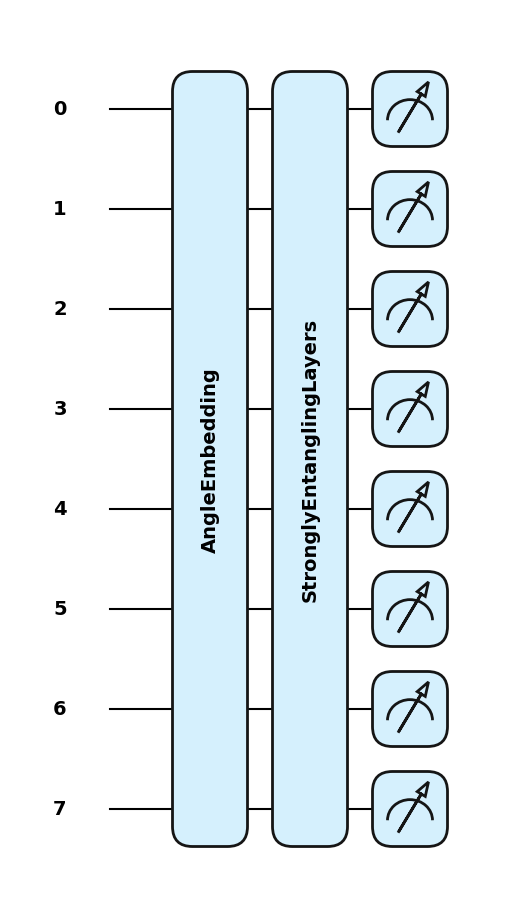

In [3]:
# Quantum device and parameters
n_qubits = 8
n_layers = 1
dev = qml.device("default.qubit", wires=n_qubits)

# Using Random Layers PQC
USE_RANDOM = False

if USE_RANDOM:
    # RandomLayers expects shape (n_layers, n_rotations_per_layer)
    # For 8 qubits, each layer typically has 3 * 8 = 24 rotations
    rand_params = np.random.uniform(0, 2 * np.pi, (n_layers, n_qubits * 3))

    @qml.qnode(dev, interface="torch", diff_method="backprop")
    def quantum_feature_embedding(f, phi):
        qml.AngleEmbedding(features=f, wires=range(n_qubits))
        RandomLayers(phi, wires=range(n_qubits), seed=6)
        return qml.state()  # returns 2**n_qubits = 256-dim statevector

# Using Strongly Entangling Layers
else:
    # StronglyEntanglingLayers expects shape (n_layers, n_wires, 3)
    rand_params = np.random.uniform(0, 2 * np.pi, (n_layers, n_qubits, 3))

    @qml.qnode(dev, interface="torch", diff_method="backprop")
    def quantum_feature_embedding(f, phi):
        qml.AngleEmbedding(features=f, wires=range(n_qubits))
        qml.StronglyEntanglingLayers(weights=phi, wires=range(n_qubits))
        return qml.state()

# Batched embedding helper
def quantum_feature_embedding_batch(x_batch, phi, device="cuda"):
    """Apply QNode to batch of inputs -> (B, 256)"""
    outputs = []
    phi = phi.detach().cpu()
    for x in x_batch:
        result = quantum_feature_embedding(x.detach().cpu(), phi)
        outputs.append(result.real.to(device))
    return torch.stack(outputs)

# Test single example
state = quantum_feature_embedding(
    torch.tensor([1/4] * n_qubits, dtype=torch.float32),
    torch.tensor(rand_params, dtype=torch.float32)
)
print("Single state shape:", state.shape)  # (256,)

# Test batch
sample = torch.randn(16, n_qubits)
phi_tensor = torch.tensor(rand_params, dtype=torch.float32)
output = quantum_feature_embedding_batch(sample, phi_tensor)
print("Batch output shape:", output.shape)  # (16, 256)

# Torch module for integration
class QuantumFeatureEmbeddingBatch(nn.Module):
    def __init__(self, device="cuda"):
        super().__init__()
        self.device = device
        self.phi = nn.Parameter(torch.tensor(
            np.random.uniform(0, 2 * np.pi, (n_layers, n_qubits * 3)), 
            dtype=torch.float32
        ))

    def forward(self, x_batch):
        outputs = []
        phi = self.phi.detach().cpu()
        for x in x_batch:
            result = quantum_feature_embedding(x.detach().cpu(), phi)
            outputs.append(result.real.to(self.device))
        return torch.stack(outputs)

# Visualize
qml.drawer.use_style('pennylane')
fig, ax = qml.draw_mpl(quantum_feature_embedding, level="device")(f=[1/4]*n_qubits, phi=rand_params)
fig.show()


In [4]:
# Multiclass DNN with Quantum Random Layer feature encoder
class MulticlassQNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Encodes features from dataset
        self.feature_encoder = QuantumFeatureEmbeddingBatch()

        # Classifies based on encoded features
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, features):
        feats_encoded = self.feature_encoder(features)
        class_probs = self.classifier(feats_encoded)

        return class_probs  # Shape: (batch_size, 1)

In [5]:
# Define variable and dataset
batch_size = 64
lr = 1e-2

X_train, y_train, X_test, y_test, X_val, y_val = Preprocess(df_train, df_test, df_val, balance = 'smote', classes = 'multiclass')

print(y_test[:])
print(y_train[:])
print(y_val[:])

train_data = ClassificationDataset(X_train, y_train)
validation_data = ClassificationDataset(X_val, y_val)
test_data = ClassificationDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(validation_data, batch_size=64, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, drop_last=True)

X_batch, y_batch = next(iter(train_loader))

print("Batch X dtype:", X_batch.dtype)
print("Batch y dtype:", y_batch.dtype)

print("Number of training samples:", len(train_data))
print("Number of validation samples:", len(validation_data))
print("Number of test samples:", len(test_data))

0      1
1      0
2      1
3      0
4      2
      ..
195    1
196    1
197    3
198    0
199    0
Name: ef_class, Length: 200, dtype: int64
0       1
1       0
2       1
3       0
4       1
       ..
1323    3
1324    3
1325    3
1326    3
1327    3
Name: ef_class, Length: 1328, dtype: int64
0      0
1      1
2      2
3      0
4      0
      ..
155    0
156    1
157    0
158    0
159    1
Name: ef_class, Length: 160, dtype: int64
Batch X dtype: torch.float32
Batch y dtype: torch.float32
Number of training samples: 1328
Number of validation samples: 160
Number of test samples: 200


In [6]:
# Initialize model, optimizer, and scheduler
n_epochs = 1000
lr = 1e-2

DNN = MulticlassQNN().to(device)
torch.nn.utils.clip_grad_norm_(DNN.parameters(), max_norm=1.0)
optimizer = optim.Adam(DNN.parameters(), lr=lr, betas=(0.9, 0.999))
scheduler_G = CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=1e-4)

# Empty array to track losses
losses = []

In [7]:
# # Plot visual of DNN
# graph =  draw_graph(
#     DNN,
#     input_size=(1, 8),
#     expand_nested=True,
#     depth = 1,
#     graph_name="DNN Architecture",
#     mode = 'train',
#     show_shapes = True,
#     hide_inner_tensors=True,   # Hides intermediate shapes
#     roll=True,                  # More compact layer grouping
#     save_graph=False,           # Set to True if you want to save
#     # node_attr={"color": "lightblue", "style": "filled"},  # Node styling
#     # edge_attr={"color": "gray"},                          # Edge styling
#     graph_dir= "TB",                         # Layout: TB (top-bottom), LR (left-right)
# )

# # Show in notebook
# graph.visual_graph

In [8]:
CrossEntropy = nn.CrossEntropyLoss()
metric = accuracy
best_val_metric = 0
best_val_loss = 999

# Initialize a dictionary to store epoch-wise results
history = {
        'epoch': [],
        'train_loss': [],
        'train_metric': [],
        'val_loss': [],
        'val_metric': []
    }


for epoch in range(n_epochs):
    DNN.train()
    train_loss, train_metric = 0.0, 0.0

    for features, target in train_loader:
        features, target = features.to(device), target.unsqueeze(-1).to(device)
        
        optimizer.zero_grad()
        outputs = DNN(features)
        loss = CrossEntropy(outputs, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_metric += metric(outputs, target)

    train_loss /= len(train_loader)
    train_metric /= len(train_loader)

    # Validation
    DNN.eval()
    val_loss, val_metric = 0.0, 0.0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.unsqueeze(-1).to(device)
            outputs = DNN(X_val)
            val_loss += CrossEntropy(outputs, y_val).item()
            val_metric += metric(outputs, y_val)

    val_loss /= len(val_loader)
    val_metric /= len(val_loader)

    # Logging
    history['epoch'].append(epoch)
    history['train_loss'].append(train_loss)
    history['train_metric'].append(train_metric)
    history['val_loss'].append(val_loss)
    history['val_metric'].append(val_metric)

    if epoch % 10 == 9:
        print(f'Epoch [{epoch+1}/{n_epochs}] | Train Loss: {train_loss:.4f} | '
        f'Train Acc: {train_metric:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_metric:.4f}')

    # Save best model
    if val_metric > best_val_metric:
        best_val_metric = val_metric
        os.makedirs("models", exist_ok=True)
        save_path = "models/DNN_model_best_accuracy.pt"
        torch.save({
            "DNN_state_dict": DNN.state_dict(),
            "history": history,
        }, save_path)
        print(f'Epoch [{epoch+1}] had best val_metric')
        
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        os.makedirs("models", exist_ok=True)
        save_path = "models/DNN_model_best_valLoss.pt"
        torch.save({
            "DNN_state_dict": DNN.state_dict(),
            "history": history,
        }, save_path)
        print(f'Epoch [{epoch+1}] had best val_Loss')
        



ValueError: Weights tensor must have second dimension of length 8; got 24

In [ ]:
## Save Model
# Create output directory if it doesn't exist

save = True
if save:
    os.makedirs("models", exist_ok=True)
    
    # Timestamp for unique filenames
    timestamp = datetime.now().strftime("%m%d_%H%M")
    
    # Save model states and tracked data in a single file
    save_path = f"models/Binary_DNN_FULLENT_AUC.6993.{timestamp}.pt"
    torch.save({
        "DNN_state_dict": DNN.state_dict(),
        "losses": losses,
    }, save_path)
    
    print(f"Model and statistics saved to {save_path}")

In [ ]:
# --- Set model to evaluation mode ---
DNN.eval()

all_targets = []
all_preds = []
all_outputs = []

with torch.no_grad():
    for features, target in test_loader:
        features = features.to(device)
        target = target.to(device).float().unsqueeze(-1)

        outputs = DNN(features)
        preds = (outputs > 0.5).float()

        all_targets.append(target.cpu())
        all_preds.append(preds.cpu())
        all_outputs.append(outputs.cpu())

# --- Concatenate all batches ---
all_targets = torch.cat(all_targets).squeeze().long().numpy()  # integers 0/1
all_preds = torch.cat(all_preds).squeeze().long().numpy()
all_outputs = torch.cat(all_outputs).squeeze().numpy()             # floats in [0,1]

# --- Sanity check ---
print(all_targets.shape, all_preds.shape, all_outputs.shape)
print(np.unique(all_targets))  # should be [0,1]

# --- Compute Metrics ---
cm = confusion_matrix(all_targets, all_preds)
auc = roc_auc_score(all_targets, all_outputs)  # should work now
f1 = f1_score(all_targets, all_preds)
acc = accuracy_score(all_targets, all_preds)

# Critical Success Index (CSI)
tp = cm[1,1]
fn = cm[1,0]
fp = cm[0,1]
csi = tp / (tp + fn + fp)

print(f"AUC: {auc:.4f}, F1: {f1:.4f}, Accuracy: {acc:.4f}, CSI: {csi:.4f}")

# --- Plot Confusion Matrix ---
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# --- Plot ROC Curve ---
fpr, tpr, thresholds = roc_curve(all_targets, all_outputs)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}', color='blue')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# --- Plot Metrics Bar Chart ---
metrics = {'Accuracy': acc, 'F1 Score': f1, 'CSI': csi}
plt.figure(figsize=(6,4))
plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'orange', 'green'])
plt.ylim(0,1)
plt.title('Classification Metrics')
plt.show()


In [ ]:
## Load a previous model
load = True

if load:
    # load_path = "models/Binary_DNN_" # Path to load model
    load_path = "models/DNN_model_best_accuracy.pt"
    # load_path = "models/DNN_model_best_valLoss.pt"
    
    # Load the checkpoint
    checkpoint = torch.load(load_path)
    
    # Restore model weights
    DNN.load_state_dict(checkpoint["DNN_state_dict"])
        
    print(f"Loaded model from {load_path}")

![image.png](attachment:7aee3b98-579c-4bcb-9682-eb417b7e3a7a.png)